# Step 0: Init the AutoML program

Run the cell to import necessary modules and training code.

In [20]:
import numpy as np
import os
import contextlib
import tensorflow as tf
import tempfile
import shutil
import zipfile
from PIL import Image
import numpy as np
import zipfile


@contextlib.contextmanager
def _tempdir():
    dirpath = tempfile.mkdtemp()
    yield dirpath
    shutil.rmtree(dirpath)


class ImageClassifier:
    def __init__(self):
        self.model = None
        self.image_size = None
        self.class_names = None

    def train(self, dataset_dir, batch_size=32, epochs=1, image_size=(160, 160), learning_rate=0.0001):
        # Step1: Data prep
        train_dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                                    seed=1337,
                                                                    validation_split=0.2,
                                                                    batch_size=batch_size,
                                                                    subset='training',
                                                                    image_size=image_size)
        validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                                         seed=1337,
                                                                         validation_split=0.2,
                                                                         batch_size=batch_size,
                                                                         subset='validation',
                                                                         image_size=image_size)
        class_names = train_dataset.class_names

        print('Number of trian batches: %d' %
              tf.data.experimental.cardinality(train_dataset))
        print('Number of validation batches: %d' %
              tf.data.experimental.cardinality(validation_dataset))
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.prefetch(
            buffer_size=tf.data.AUTOTUNE)

        # Step2: Model Architecture

        # Skip the data_augmentation because
        # https://stackoverflow.com/questions/69955838/saving-model-on-tensorflow-2-7-0-with-data-augmentation-layer
        #
        # data_augmentation = tf.keras.Sequential([
        #     tf.keras.layers.RandomFlip('horizontal'),
        #     tf.keras.layers.RandomRotation(0.2),
        # ])
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        image_shape = image_size + (3,)
        base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                       include_top=False,
                                                       weights='imagenet')
        base_model.trainable = True
        fine_tune_at = 100
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        inputs = tf.keras.Input(shape=image_shape)
        x = inputs
        # x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(len(class_names))(x)
        outputs = tf.nn.softmax(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False),
            metrics=['accuracy'])
        model.summary()

        # Step 3: Start training
        history = model.fit(train_dataset,
                            epochs=epochs,
                            validation_data=validation_dataset)

        # Step 4: Evaluation
        if validation_dataset:
            loss, accuracy = model.evaluate(validation_dataset)
            print('Test accuracy :', accuracy)

            # Retrieve a batch of images from the test set
            image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
            predictions = model.predict_on_batch(image_batch)

            # Apply softmax and argmax to find the most possible class
            predictions = model.predict_on_batch(image_batch)
            predictions = tf.math.argmax(predictions, axis=-1)
            print('Predictions:\n', predictions.numpy())
            print('Labels:\n', label_batch)

        self.model = model
        self.class_names = class_names
        self.image_size = (160, 160)
        image_size = (160, 160)

        return history

    def save(self, modelfile):
        with _tempdir() as modelpath:
            self.model.save(modelpath)
            with open(f'{modelpath}/class_names.txt', 'w') as f:
                for class_name in self.class_names:
                    print(class_name, file=f)

            with zipfile.ZipFile(modelfile, 'w', zipfile.ZIP_DEFLATED) as zf:
                for dirname, subdirs, files in os.walk(modelpath):
                    arc_dirname = dirname[len(modelpath):]
                    print(f'dir : {arc_dirname}/')
                    zf.write(dirname, arc_dirname)
                    for filename in files:
                        print(f'file: {arc_dirname}/{filename}')
                        zf.write(os.path.join(dirname, filename),
                                 os.path.join(arc_dirname, filename))

    def load(self, modelfile):
        with _tempdir() as dirpath:
            with zipfile.ZipFile(modelfile, 'r') as zip_ref:
                zip_ref.extractall(dirpath)
            model = tf.keras.models.load_model(dirpath)
            with open(f"{dirpath}/class_names.txt") as f:
                class_names = f.readlines()
            class_names = [class_name.strip() for class_name in class_names]

        self.image_size = (160, 160)
        self.class_names = (class_names)
        self.model = model

    def predict(self, img_path):
        with Image.open(img_path) as image:
            image = image.resize(self.image_size).convert("RGB")
            x = tf.keras.preprocessing.image.img_to_array(image)
            x = tf.expand_dims(x, 0)
        result = self.model(x)
        result = tf.squeeze(result)
        cls_idx = int(tf.math.argmax(result, axis=-1))
        cls = self.class_names[cls_idx]
        return (cls, result.numpy())

    def predict_img(self, image):
        image = image.resize(self.image_size).convert("RGB")
        x = tf.keras.preprocessing.image.img_to_array(image)
        x = tf.expand_dims(x, 0)
        result = self.model(x)
        result = tf.squeeze(result)
        cls_idx = int(tf.math.argmax(result, axis=-1))
        cls = self.class_names[cls_idx]
        return (cls, result.numpy())


# Step 1: Prepare the dataset

The dataset should be a 'zip' file with the following format.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```  

Please see the document in tensorflow
https://www.tensorflow.org/tutorials/load_data/images


There are two way to prepare the dataset

1. Load from local file
1. Download from public url

After the step 1, the variable of `dataset_dir` should be set as the directory of your dataset.

## Option 1: Download the example dataset

If you would like to have a quick try, you can use the tensorflow example dataset.

In [21]:
_DATASET_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

!wget $_DATASET_URL

import os
import tempfile

basename = os.path.basename(_DATASET_URL)

with zipfile.ZipFile(basename, 'r') as zip_ref:
    zip_ref.extractall(".")

base, ext = os.path.splitext(basename)
dataset_dir = f"{base}/train"
print(f"dataset dir: {dataset_dir}")

--2022-01-04 16:18:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.2’

cats_and_dogs_filte 100%[===================>]  65.43M  22.4MB/s    in 2.9s    

2022-01-04 16:18:59 (22.4 MB/s) - ‘cats_and_dogs_filtered.zip.2’ saved [68606236/68606236]

dataset dir: cats_and_dogs_filtered/train


## Option 2: Use your own dataset

If you would like to prepare your special dataset, you can use the project [simple_image_download](https://github.com/RiddlerQ/simple_image_download) to download images from google search. But it seems there are some problem if we run it in colab, I recommend to prepare the dataset in your local machine, and upload to colab.

1. Clone the auto-img-cls
   ```
   git clone git@github.com:InfuseAI/auto-img-cls.git
   cd auto-img-cls
   ```
1. Install `simple_image_download`
   ```
   pip install simple_image_download
   ```
1. Edit the `download.py`. Change the keywords of images you would like to download
   ```
   #download.py
   from simple_image_download import simple_image_download as simp

   response = simp.simple_image_download
   response().download('apple,banana,guava', 50)
   ```
1. Run python script
   ```
   python ./download
   ```
  
   The downloaded image will go to `simple_images` folder.
1. rename, zip, and upload to colab
1. Run the below code cell to unzip and set the variable `dataset_dir`

In [11]:
_DATASET_FILE = '/content/cats_and_dogs_50.zip'

import os
import tempfile

with zipfile.ZipFile(_DATASET_FILE, 'r') as zip_ref:
    zip_ref.extractall(".")

basename = os.path.basename(_DATASET_FILE)
dataset_dir, ext = os.path.splitext(basename)

print(f"dataset dir: {dataset_dir}")

dataset dir: cats_and_dogs_50


# Step 2: Train

Now, we have dataset. Then we will start to train the dataset.

Most of the time, the step should not be a single run, we should adjust the parameters (or said hyperparameter) to get the best result.

There are three parameter we can adjust
1. `EPOCHS`: how many times we should go through the whole dataset
2. `BATCH_SIZE`: how many data we should update the weights
3. `LEARNING_RATE`: how big step we should update the weights for each batch

In the training process, we will split the dataset into two part
- Training set (80%): use to train and update the weight
- Validation set (20%): use to validate the model

The goal for each experiment is to get the best accuracy in the validation dataset.

In [23]:
EPOCHS = 2
BATCH_SIZE = 30
LEARNING_RATE = 0.0001

classifier = ImageClassifier()
history = classifier.train(dataset_dir, epochs=EPOCHS, learning_rate=LEARNING_RATE)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
Number of trian batches: 50
Number of validation batches: 13
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                            

# Step 3: Predict

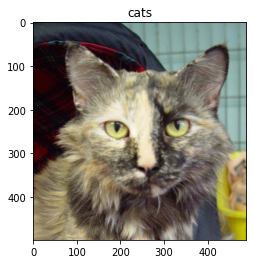

predict: cats
class_names: ['cats', 'dogs']
probability: [9.999999e-01 6.010972e-08]


In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as img

_IMG_PATH="/content/cats_and_dogs_50/train/cats/cat.10.jpg"

image = img.imread(_IMG_PATH)
cls, probs = classifier.predict(_IMG_PATH)

plt.title(cls)
plt.imshow(image)
plt.show()

print(f"predict: {cls}")
print(f"class_names: {classifier.class_names}")
print(f"probability: {probs}")

# Step 4: Save and Load

## Save the model

In [ ]:
_MODEL_FILE="model.zip"

classifier.save(_MODEL_FILE)

INFO:tensorflow:Assets written to: /tmp/tmp80ymkhno/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


dir : /
file: /keras_metadata.pb
file: /class_names.txt
file: /saved_model.pb
dir : /assets/
dir : /variables/
file: /variables/variables.index
file: /variables/variables.data-00000-of-00001


## Load the model

In [25]:
_MODEL_FILE="model.zip"

classifier=ImageClassifier()
classifier.load(_MODEL_FILE)


# Step 5: Package and deploy the model

1. Download the model to your local machine
2. The model name should be `model.zip`
3. Build the docker image
   ```
   docker build --tag cats_and_dogs .
   ```
3. Run the docker image
   ```
   docker run -p 8501:8501 cats_and_dogs
   ```
5. Check http://localhost:8501. 
6. Cheers!! You have your own image classifier!!